In [1]:
from os import P_NOWAIT
from numpy.core.defchararray import array, index
from sklearn.utils.validation import check_random_state
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import KFold, StratifiedKFold 
import pandas as pd
from tensorflow.python.autograph.operators.py_builtins import print_
from tensorflow.python.keras.backend import backend, clear_session
import os
from numpy import asarray
from PIL import Image
from matplotlib import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
#localização das pastas do teste e do treino
train = '/content/drive/MyDrive/Colab Notebooks/train'

data_train = [] 
data_test = []

#teste 
treino_M_treino_B = '/content/drive/MyDrive/Colab Notebooks/train'

#treinamento
treino_M = '/content/drive/MyDrive/Colab Notebooks/train/M'
treino_B = '/content/drive/MyDrive/Colab Notebooks/train/B'

treino_M = ['/content/drive/MyDrive/Colab Notebooks/train/M/{}'.format(i) for i in os.listdir(treino_M)]
treino_B = ['/content/drive/MyDrive/Colab Notebooks/train/B/{}'.format(i) for i in os.listdir(treino_B)]

data_labels = []

for i in treino_B:
  data_labels.append(0)# benigno = 0 maligno = 1

for i in treino_M:
  data_labels.append(1)# benigno = 0 maligno = 1

data_train = treino_B + treino_M #benigno e maligno 

In [3]:
data_train_labels = [] #criando uma lista de imagens e labels

#tranformei todos os dados da lista data_train em uma lista (lista aninhada)
for i in data_train:
  data_train_labels.append([i])

#adicionado o label em cada lista 
for i in range (0, len(data_train_labels)):
    data_train_labels[i].append(data_labels[i])

#dataframe

In [4]:
colunas = ['treinamento', 'teste'] #criando as colunas

df = pd.DataFrame(data=data_train_labels, columns = colunas)

#Validação do modelo | Kfold

In [5]:
idg = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [6]:
df['treinamento'] = df['treinamento'].astype(str)
df['teste']= df['teste'].astype(str)

#print(type(df.treinamento))
#print(type(df.teste))

In [7]:
x = df['treinamento']
Y = df[['teste']]
save_dir = '/content/drive/MyDrive/Colab Notebooks/teste/saved_models/'


fold_var = 1

kfold = KFold(5, True, 1)

for train, test in kfold.split(np.zeros(x.shape[0]), Y):

  training_data = df.iloc[train]
  validation_data = df.iloc[test]
  #print('validation_data')
  #print(validation_data.size)

  train_data_generator = idg.flow_from_dataframe(training_data,directory=None,
		x_col = "treinamento",
    y_col = "teste",
    class_mode = "categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle = True)
  
  valid_data_generator  = idg.flow_from_dataframe(validation_data,directory=None,
    x_col = "treinamento",
    y_col = "teste",
    class_mode = "categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle = True)


  #Instanciando o modelo VGG16
  vgg = keras.applications.vgg16.VGG16(
    input_shape = (224,224,3),
    weights = 'imagenet', #pesos pré-treinados do imagenet (transfer-learning workflow)
    include_top = False
  )

  #vgg.input
  vgg.output

  #"congelar" o modelo básico
  for layer in vgg.layers:
    layer.trainable = False

  x = keras.layers.Flatten()(vgg.output)
  prediction = keras.layers.Dense(2, activation='softmax')(x) #duas classes (B e M)
  my_model = keras.Model(inputs=vgg.input, outputs=prediction)
  #my_model.summary()

  adam = keras.optimizers.Adam()

  #compilando o model
  my_model.compile(
      loss='categorical_crossentropy',
		  optimizer=adam,
		  metrics=['accuracy']
      )
  
  #treinamento da rede
  #*********************************************************
  '''
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var),
                                                  monitor='val_accuracy', verbose=1,
                                                  save_best_only=True, mode='max')

  callbacks_list = [checkpoint]
  
  history = my_model.fit(train_data_generator,
                              validation_data=valid_data_generator,
                              epochs = 6,#6
                              verbose=1,
                              callbacks=callbacks_list)

  #print(my_model_fit)
  my_model.load_weights("/content/drive/MyDrive/Colab Notebooks/teste/saved_models/model_"+str(fold_var)+".h5")

  results = my_model.evaluate(valid_data_generator)
  '''
  #*********************************************************

  tf.keras.backend.clear_session()

  fold_var += 1

Found 93 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
58900480/58889256 [==============================] - 0s 0us/step
Found 93 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 94 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.
Found 94 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.
Found 94 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.


#Testando uma imagem (M)

output
[[0.9491137  0.05088628]]


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



**************************************

0
Benigno


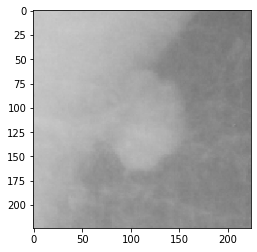

In [8]:
img = keras.preprocessing.image.load_img("/content/drive/MyDrive/Colab Notebooks/mdb270.PNG",target_size=(224,224)) #M
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

#saved_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/teste/saved_models/model_1.h5")
#print(saved_model)

output = my_model.predict(img)

print('output')
print(output)

predictions = my_model.predict_generator(img)

#print('predictions')
#print(predictions)

print("\n**************************************\n")

argmax = np.argmax(predictions)
print(np.argmax(predictions)) #classe

if(argmax == 0):
    print('Benigno')

if(argmax == 1):
     print("Maligno")

# Confusion matrix | Specificity and Sensitivity




In [9]:
tam = valid_data_generator.classes

cont = 0
for i in tam:
  if(i == 0):
    cont+=1

#print(cont)

model_1.h5
Sensibilidade = 0.0 | Especificidade = 1.0

model_2.h5
Sensibilidade = 1.0 | Especificidade = 0.0

model_3.h5
Sensibilidade = 0.875 | Especificidade = 0.0

model_4.h5
Sensibilidade = 0.9375 | Especificidade = 0.0

model_5.h5
Sensibilidade = 1.0 | Especificidade = 0.0


Sensibilidade Total = 0.7625 | Especificidade Total = 0.2



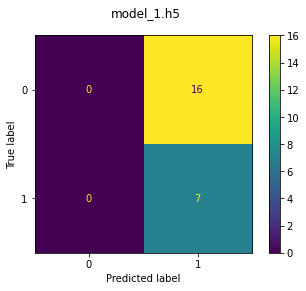

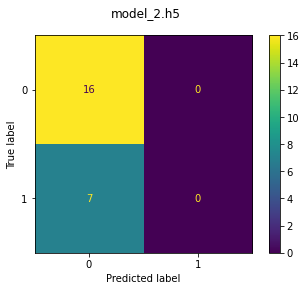

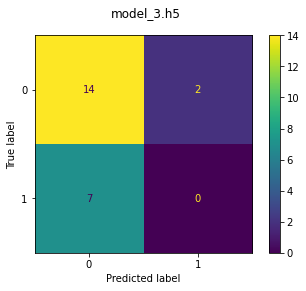

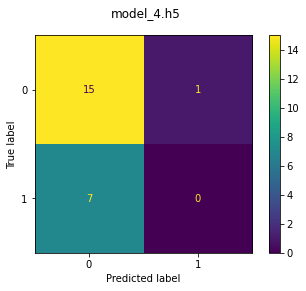

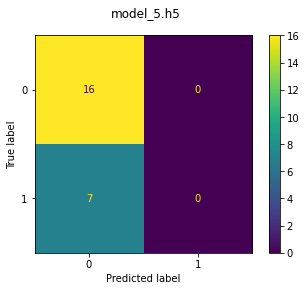

In [10]:
#Função que calcula uma confusion_matrix para todos os models gerados 

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import ConfusionMatrixDisplay

teste = []

def confusion_matrix_model(model, i):
  classes = [0,1]

  predict = model.predict(valid_data_generator)
  y_pred = np.argmax(predict, axis=1)
  y_true = valid_data_generator.classes
  cm = confusion_matrix(y_true, y_pred)
  
  teste.append(cm[0][0])
  teste.append(cm[1][1])

  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= classes)
  cm_display.plot()
  plt.suptitle(i)

caminho = '/content/drive/MyDrive/Colab Notebooks/teste/saved_models'

j=0
sensibility_total =0
specificity_total=0

for i in os.listdir(caminho):
  m = '/content/drive/MyDrive/Colab Notebooks/teste/saved_models/{}'.format(i)
  m = keras.models.load_model(m)
  confusion_matrix_model(m, i)
    
  tam = len(valid_data_generator.filenames)

  #Sensibilidade = casos positivos corretos 
  sensibility = teste[j] / cont
  sensibility_total += sensibility

  #Especificidade = casos negativos corretos
  specificity =  teste[j+1] / (tam - cont)
  specificity_total += specificity

  print('{}\nSensibilidade = {} | Especificidade = {}\n'.format(i, sensibility, specificity))
  j+=2

#Sensibilidade e Especificidade total
print('\nSensibilidade Total = {} | Especificidade Total = {}\n'.format((sensibility_total / (j/2)), (specificity_total/ (j/2))))

#print(sensibility_total)
#print(specificity_total)


# Curva roc

# https://www.flai.com.br/juscudilio/como-calcular-as-metricas-de-validacao-dos-modelos-de-machine-learning-em-python/

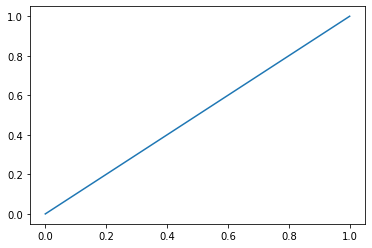

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot

saved_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/teste/saved_models/model_1.h5")

predict = saved_model.predict(valid_data_generator)
y_pred = np.argmax(predict, axis=1)
y_true = valid_data_generator.classes

y_pred = y_pred.tolist() #convertendo para lista

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc  = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)


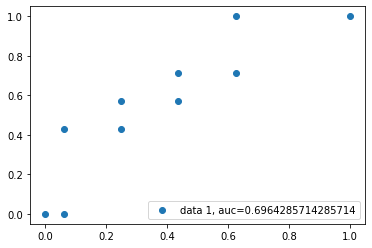

In [ ]:
#teste 1

import sklearn 

saved_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/teste/saved_models/model_1.h5")
y_test = valid_data_generator.classes

y_pred_probability = saved_model.predict(valid_data_generator)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probability)

auc = metrics.roc_auc_score(y_test, y_pred_probability)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#teste 2 | erro 

import sklearn 

saved_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/teste/saved_models/model_1.h5")
y_test = valid_data_generator.classes

y_pred_probability = saved_model.predict(valid_data_generator)
y_pred = np.argmax(y_pred_probability, axis=1)

fpr, tpr = metrics.roc_curve(y_test,y_pred)

auc = metrics.roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# teste 3 | erro ?
saved_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/teste/saved_models/model_1.h5")

predict = saved_model.predict(valid_data_generator)
y_pred = np.argmax(predict, axis=1)
y_true = valid_data_generator.classes

print("y_test", y_test)
print("y_pred", y_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=2)
metrics.auc(fpr, tpr)

# Accuracy

In [ ]:
# Accuracy de cada modelo | correto

from sklearn import metrics        
saved_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/teste/saved_models/model_1.h5")

predict = saved_model.predict(valid_data_generator)
y_pred = np.argmax(predict, axis=1)
y_test = valid_data_generator.classes

print("y_test", y_test)
print("y_pred", y_pred)

print("Accuracy", metrics.accuracy_score(y_test, y_pred))


In [ ]:
'''
import numpy as np
from sklearn import metrics

y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])

fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)
'''